In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Algorithms
from sklearn.svm import SVC

# Internal
from autocat.data.datasets import get_training_data, get_totals_data
from autocat.data.features import CombinedFeatureAdder, feature_transactions_per_day, PandasDataFrameTransformer
from autocat.data.filters import FeatureFilters, no_null_StdUnitsShipped_StdNetAmount
from autocat.models import GridSearchModel, Model
from autocat.models.evaluation import plot_learning_curve, get_scorer, financial_loss_scorer
from autocat.models.pipelines import get_scaled_pipeline_v1

## Pipeline

In [4]:
TRAINING_DATA = '../data/processed/train_2018-08-24.csv'

# Create feaure matrix and label vector
X, y = get_training_data(TRAINING_DATA, [
    no_null_StdUnitsShipped_StdNetAmount
], drop_na=True)

In [5]:
# Get the scaled pipeline
pipeline = get_scaled_pipeline_v1(X)
print(pipeline)

Pipeline(memory=None,
     steps=[('feaure_transactions_per_day', CombinedFeatureAdder(attribute_fn=<function feature_transactions_per_day at 0x1a09d6ab70>)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('data_frame', PandasDataFrameTransformer(columns=['AvgUnitsShipped', 'StdUnitsShipped', 'MinUnitsShipped', 'MaxUnitsShipped', 'AvgNetAmount', 'StdNetAmount', 'MinNetAmount', 'MaxNetAmount', 'NumberOfTransactions', 'NumberOfTransactionDays', 'TransactionsPerDay']))])


In [6]:
print('Training instances:', len(X))

Training instances: 5610


## Scorer

In [7]:
totals_data = get_totals_data()
scorer = make_scorer(financial_loss_scorer, totals=totals_data, greater_is_better=False)

## Model

In [8]:
# Create existing model
model_base = SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svm_model = Model('svm', model_base, pipeline).fit(X, y)
print('Existing model spec:\n', svm_model.model)

Existing model spec:
 SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Evaluation

In [11]:
X_transformed = svm_model.pipeline.transform(X)
model_predictions = svm_model.model.predict(X_transformed)

#### Training Set

In [12]:
results = svm_model.score(X, y, scorer)
print('Score:', results[0])
print(classification_report(y, svm_model.model.predict(svm_model.pipeline.fit_transform(X))))

Score: -18351224.58
                      precision    recall  f1-score   support

           Body Care       0.75      0.79      0.77       936
              Frozen       0.95      0.06      0.11       308
                Meat       1.00      0.74      0.85       102
    Packaged Grocery       0.73      0.96      0.83      3005
        Packaged Tea       1.00      0.05      0.10       222
Refrigerated Grocery       0.78      0.46      0.58       595
            Vitamins       0.70      0.36      0.47       442

         avg / total       0.76      0.74      0.70      5610



#### Cross Validation

In [10]:
CV=10

##### Financial Loss

In [14]:
cv_scores = cross_val_score(svm_model.get_model_pipeline(), X, y, scoring=scorer, cv=CV)
cv_scores.mean()

-2817604.2989999996

##### F1

In [15]:
cv_predictions = cross_val_predict(svm_model.get_model_pipeline(), X, y, cv=CV)
print(f1_score(y, cv_predictions, average='micro'))
print(classification_report(y, cv_predictions))

0.6994652406417112
                      precision    recall  f1-score   support

           Body Care       0.70      0.75      0.73       936
              Frozen       0.12      0.01      0.02       308
                Meat       0.84      0.58      0.69       102
    Packaged Grocery       0.71      0.93      0.80      3005
        Packaged Tea       0.36      0.02      0.03       222
Refrigerated Grocery       0.72      0.40      0.51       595
            Vitamins       0.55      0.26      0.36       442

         avg / total       0.65      0.70      0.65      5610



#### Confusion Matrix

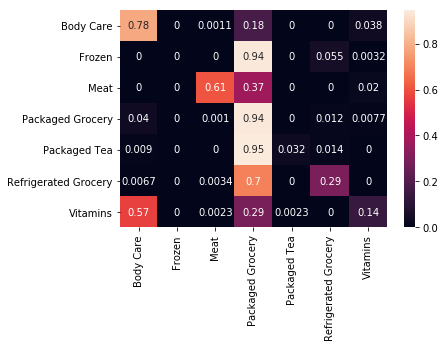

In [130]:
conf_mat = confusion_matrix(y, cv_predictions, labels=np.sort(y.unique()))
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

conf_mat_props = pd.DataFrame(
    conf_mat_df.values / conf_mat_df.sum(axis=1)[:,None],
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

sns.heatmap(conf_mat_props, annot=True);

In [131]:
conf_mat_props.apply(lambda x: (x == 0).sum()).mean()

3.0

#### Learning Curve

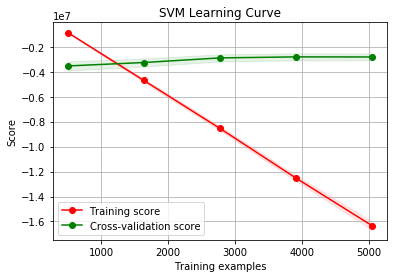

In [11]:
# Plot the learning curve
plot_learning_curve(svm_model.get_model_pipeline(), 'SVM Learning Curve (Financial Loss)', X, y, cv=CV, scoring=scorer);

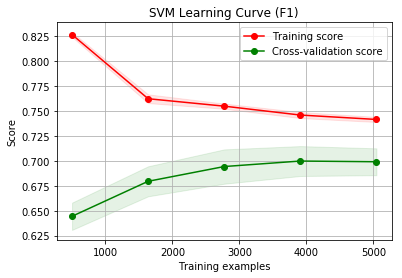

In [12]:
# Plot the learning curve
plot_learning_curve(svm_model.get_model_pipeline(), 'SVM Learning Curve (F1)', X, y, cv=CV, scoring=make_scorer(f1_score, average='micro'));

Overall, the SVM model trained with financial loss appears to make more misclassifications but the classifications result in a lower financial loss.